In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import datetime
import seaborn as sns

from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import check_cv
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
import os
os.listdir(os.getcwd())

['Feb17_Literature Review_KN (edit draft here).docx',
 '~$rch 23_KN (clean copy here).docx',
 'Exploratory data -Olympics venues',
 'Data Mining Techniques for Predicting Real Estate Trends.pdf',
 'Exploratory data.ipynb',
 'Predict_Prices_Airbnb_3Cities.pdf',
 'Prediction.ipynb',
 '.DS_Store',
 'Mar_cal.csv',
 'Airbnb Price prediction.pdf',
 'Untitled.ipynb',
 'Jan27_KN_Abstract.pdf',
 'WuYu_HousingPrice_report.pdf',
 'Machine Learning Project_ Predicting Boston House Prices With Regression.pdf',
 'Big_Data_in_Real_Estate_From_.pdf',
 'Feb24_Literature Review_KN (clean copy here).docx',
 'TTS_dataset',
 'Neighbourhoods & Olympic venues.ipynb',
 'Multi-Scale clustering.pdf',
 'March 23_KN (clean copy here).docx',
 'Abstract.docx',
 'CKME_136_Data_Analytics__Capstone_Course_Winter_2020.pdf',
 '.ipynb_checkpoints',
 'Nov_listing.csv',
 'Estimating_the_Performance_of_.pdf',
 'Mar_listing.csv',
 'Initial results.ipynb',
 'Housing_Value_Forecasting_Base.pdf',
 'Price reco on Airbnb.pdf',
 '

In [3]:
Nov_cal = pd.read_csv('Nov_cal.csv')
print('The duration of Nov_cal data is between {} and {}.'.format(Nov_cal['date'].min(), Nov_cal['date'].max()))

The duration of Nov_cal data is between 2019-11-29 and 2020-11-27.


In [4]:
Nov_cal.shape[0]

1048575

In [5]:
Nov_listing = pd.read_csv('Nov_listing.csv')
print('The duration of Nov_listing data is between {} and {}.'.format(Nov_listing['last_scraped'].min(), Nov_listing['last_scraped'].max()))

The duration of Nov_listing data is between 2019-11-28 and 2019-12-07.


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
Nov_listing.shape[0]

13762

In [7]:
Mar_cal = pd.read_csv('Mar_cal.csv')
print('The duration of Mar_cal data is between {} and {}.'.format(Mar_cal['date'].min(), Mar_cal['date'].max()))

The duration of Mar_cal data is between 2019-03-25 and 2020-03-23.


In [8]:
Mar_listing = pd.read_csv('Mar_listing.csv')
print('The duration of Mar_listing data is between {} and {}.'.format(Mar_listing['last_scraped'].min(), Mar_listing['last_scraped'].max()))

The duration of Mar_listing data is between 2019-03-25 and 2019-03-25.


In [9]:
Mar_listing.shape[0]

9769

In [10]:
#Drop rows from "Nov_cal" that falls between 2019-11-29 and 2020-03-23
end_date = '2020-03-23'
mask = (Nov_cal['date'] > end_date)
Nov_cal2 = Nov_cal.loc[mask]
print('The duration of Nov_cal2 data is between {} and {}.'.format(Nov_cal2['date'].min(), Nov_cal2['date'].max()))

The duration of Nov_cal2 data is between 2020-03-24 and 2020-11-27.


In [11]:
#Merge both calendar data from March 2019-November 2019 and November 2019-December 2020 (Mar_cal with Nov_cal2)
frame = [Mar_cal, Nov_cal2]
calendar = pd.concat(frame)
print('The duration of calendar data is between {} and {}.'.format(calendar['date'].min(), calendar['date'].max()))

The duration of calendar data is between 2019-03-25 and 2020-11-27.


In [12]:
#Merge both listing data (as of March 2019 and Dec 2019) for comparison and consistency with calendar data
frame2 = [Mar_listing, Nov_listing]
listing = pd.concat(frame2)
print('The duration of listing data is between {} and {}.'.format(listing['last_scraped'].min(), listing['last_scraped'].max()))

The duration of listing data is between 2019-03-25 and 2019-12-07.


In [13]:
#Drop rows from calendar that falls between 2019-03-25 and 2019-03-31; between 2019-12-01 and 2019-12-07
start_date = '2019-03-31'
mask2 = (calendar['date'] > start_date)
calendar = calendar.loc[mask2]
print('The duration of updated calendar data is between {} and {}.'.format(calendar['date'].min(), calendar['date'].max()))

The duration of updated calendar data is between 2019-04-01 and 2020-11-27.


In [14]:
calendar.shape[0]

4212493

In [15]:
listing.shape[0]

23531

In [16]:
#Change all price variables to float and remove $ sign
calendar["price"] = calendar["price"].str.replace("[$, ]", "").astype(float)
calendar["adjusted_price"] = calendar["adjusted_price"].str.replace("[$, ]", "").astype(float)
listing['price'] = listing['price'].str.replace("[$, ]", "").astype(float)
listing['weekly_price'] = listing['weekly_price'].str.replace("[$, ]", "").astype(float)
listing['monthly_price'] = listing['monthly_price'].str.replace("[$, ]", "").astype(float)

In [17]:
#Find out insights on prices from 'calendar' prior to data processing
print('The maximum price is {}.'.format(calendar['price'].max()))
print('The minimum price is {}.'.format(calendar['price'].min()))
print('The average price is {}.'.format(calendar['price'].mean()))

The maximum price is 13109645.0.
The minimum price is 1099.0.
The average price is 19858.311488482035.


In [19]:
# The maximum price looks like an outlier. Therefore, we'll drop outliers.
# One definition of outlier is any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.
# Computing IQR
Q1 = calendar['price'].quantile(0.25)
Q3 = calendar['price'].quantile(0.75)
IQR = Q3 - Q1

In [20]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
calendar = calendar.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')
calendar.shape[0]

3927797

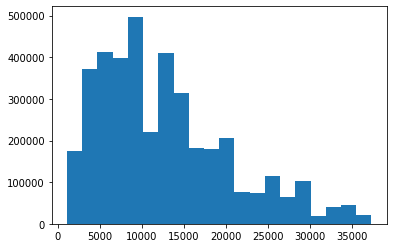

In [21]:
plt.hist(calendar['price'], bins = 20);

In [22]:
print('The maximum number of nights is {}.'.format(calendar['maximum_nights'].max()))
print('The minimum number of nights is {}.'.format(calendar['maximum_nights'].min()))
print('The average number of nights is {}.'.format(calendar['maximum_nights'].mean()))

The maximum number of nights is 3000.
The minimum number of nights is 1.
The average number of nights is 735.5821191879315.


In [23]:
#Drop rows where maximum nights is more than 180 nights (6 months)#
max_nights = 181
mask3 = (calendar['maximum_nights'] < max_nights)
new_calendar = calendar[mask3]
new_calendar.shape[0]

1075298

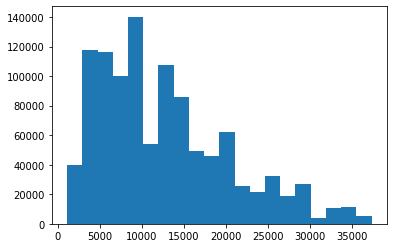

In [24]:
plt.hist(new_calendar['price'], bins = 20);

In [25]:
print('The maximum price is {}.'.format(listing['price'].max()))
print('The minimum price is {}.'.format(listing['price'].min()))
print('The average price is {}.'.format(listing['price'].mean()))

The maximum price is 1063900.0.
The minimum price is 0.0.
The average price is 17328.215290467895.


In [26]:
# The maximum price looks like an outlier. Therefore, we'll drop outliers.
# One definition of outlier is any data point more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.
# Computing IQR
Q1 = listing['price'].quantile(0.25)
Q3 = listing['price'].quantile(0.75)
IQR = Q3 - Q1

In [27]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
listing = listing.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')
listing.shape[0]

21901

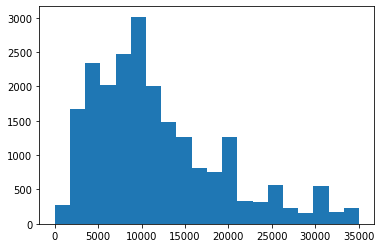

In [28]:
plt.hist(listing['price'], bins=20);

In [29]:
# Create a column that corresponds t/f value in the available column
new_calendar['available_t'] = new_calendar['available'].apply(lambda x: 1 if x == 't' else 0)
new_calendar['available_f'] = new_calendar['available'].apply(lambda x: 1 if x == 'f' else 0)
new_calendar['available_total'] = new_calendar['available'].apply(lambda x: 1 if x == 'f' else 1)
new_calendar.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,available_t,available_f,available_total
737,289597,2019-04-01,f,4508.0,4508.0,30,180,0,1,1
738,289597,2019-04-02,f,4508.0,4508.0,30,180,0,1,1
739,289597,2019-04-03,f,4508.0,4508.0,30,180,0,1,1
740,289597,2019-04-04,f,4508.0,4508.0,30,180,0,1,1
741,289597,2019-04-05,f,4508.0,4508.0,30,180,0,1,1


In [30]:
# Change dtype of date column to datetime
new_calendar['date'] = pd.to_datetime(new_calendar['date'])
new_calendar['date'].head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


737   2019-04-01
738   2019-04-02
739   2019-04-03
740   2019-04-04
741   2019-04-05
Name: date, dtype: datetime64[ns]

In [31]:
# Rename 'id' variable in listing to 'listing_id'
listing = listing.rename(index=str, columns={"id": "listing_id"})

In [32]:
# Merge listing dataframe and 'month' in calendar dataframe
# Create a column that holds month data in calendar dataframe
new_calendar['month'] = new_calendar.date.dt.month
df_calendar = new_calendar.drop(['date','available','adjusted_price','price'], axis=1)
df_listing = listing.drop(['minimum_nights','maximum_nights'], axis=1)

# Merge calendar and listing data onmerge
df_new = pd.merge(df_calendar, df_listing, on = 'listing_id')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df_new.head()

,listing_id,minimum_nights,maximum_nights,available_t,available_f,available_total,month,listing_url,scrape_id,last_scraped,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,289597,30,180,0,1,1,4,https://www.airbnb.com/rooms/289597,2.019033e+13,2019-03-25,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.27
1,289597,30,180,0,1,1,4,https://www.airbnb.com/rooms/289597,2.020000e+13,2019-11-29,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.22
2,289597,30,180,0,1,1,4,https://www.airbnb.com/rooms/289597,2.019033e+13,2019-03-25,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.27
3,289597,30,180,0,1,1,4,https://www.airbnb.com/rooms/289597,2.020000e+13,2019-11-29,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.22
4,289597,30,180,0,1,1,4,https://www.airbnb.com/rooms/289597,2.019033e+13,2019-03-25,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,1.27


In [34]:
# Find percentage of missing values in each column in Listing dataset
listing_missing_df = listing.isnull().mean()*100
listing_missing_df
# Filter out only the columns with missing values, showing the percentage of missing values in each column.
listing_nan_cols = listing_missing_df[listing_missing_df > 0]
listing_nan_cols

summary                           1.059312
space                            13.122688
description                       0.904068
neighborhood_overview            21.263869
notes                            25.140405
transit                          15.958175
access                           27.313821
interaction                      24.446372
house_rules                      40.801790
thumbnail_url                   100.000000
medium_url                      100.000000
xl_picture_url                  100.000000
host_name                         0.050226
host_since                        0.050226
host_location                     0.095886
host_about                       28.364002
host_response_time                2.972467
host_response_rate                2.972467
host_acceptance_rate            100.000000
host_is_superhost                 0.050226
host_thumbnail_url                0.050226
host_picture_url                  0.050226
host_neighbourhood               13.752797
host_listin

In [35]:
# Drop columns with null values of 12% and above (mostly listing descriptions data), except review scores data & 
# 'latitude', 'longitude'.
# The columns to drop are thumbnail_url, medium_url, xl_picture_url, host_acceptance_rate, 
# neighbourhood_group_cleansed, jurisdiction_names, square_feet, weekly_price, monthly_price, house_rules,
# host_about, access, interaction, notes, neighborhood_overview, transit, host_neighborhood, space, 
# 'host_since','thumbnail_url','medium_url','xl_picture_url','host_acceptance_rate','neighbourhood_group_cleansed',
# 'square_feet','weekly_price','monthly_price','jurisdiction_names','listing_id','listing_url','scrape_id','last_scraped','name','summary','space',
# 'description','experiences_offered','neighborhood_overview','notes','transit','access','interaction','house_rules','thumbnail_url','medium_url',
# 'picture_url','xl_picture_url','host_id','host_url','host_name','host_location','host_about','host_thumbnail_url',
# 'host_picture_url','neighbourhood','street','host_neighbourhood','host_verifications','smart_location','state','city',
# 'market','country_code','country','zipcode','amenities','calendar_updated','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
# 'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_last_scraped','first_review','last_review','license',
# 'cancellation_policy','require_guest_profile_picture','require_guest_phone_verification','price_pp','calculated_host_listings_count',
# 'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'

columns_to_drop = ['thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate', 
                   'neighbourhood_group_cleansed', 'jurisdiction_names', 'square_feet', 'weekly_price', 
                   'monthly_price', 'house_rules', 'host_about', 'access', 'interaction', 'notes', 
                   'neighborhood_overview', 'transit', 'host_neighbourhood', 'space','host_since',
                   'thumbnail_url','medium_url','xl_picture_url','host_acceptance_rate',
                   'neighbourhood_group_cleansed','square_feet','weekly_price','monthly_price','jurisdiction_names',
                   'listing_id','listing_url','scrape_id','last_scraped','name','summary','space','description',
                   'experiences_offered','neighborhood_overview','notes','transit','access','interaction','house_rules',
                   'thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url','host_name','host_location',
                   'host_about','host_thumbnail_url','host_picture_url','neighbourhood','street','host_neighbourhood','host_verifications',
                   'smart_location','state','city','market','country_code','country','zipcode','amenities','calendar_updated',
                   'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
                   'maximum_nights_avg_ntm','calendar_last_scraped','first_review','last_review','license','cancellation_policy',
                   'require_guest_profile_picture','require_guest_phone_verification','calculated_host_listings_count',
                   'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms']
df_new_clean = df_new.drop(columns_to_drop, axis=1)
df_new_clean.dropna(inplace=True)
df_new_clean.shape[0]

1642972

In [36]:
df_new_clean.head()

,minimum_nights,maximum_nights,available_t,available_f,available_total,month,host_response_time,host_response_rate,host_is_superhost,host_listings_count,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,reviews_per_month
0,30,180,0,1,1,4,within a day,70%,f,2.0,...,9.0,10.0,10.0,9.0,9.0,10.0,t,t,f,1.27
1,30,180,0,1,1,4,within an hour,100%,f,2.0,...,9.0,10.0,10.0,9.0,9.0,9.0,t,t,f,1.22
2,30,180,0,1,1,4,within a day,70%,f,2.0,...,9.0,10.0,10.0,9.0,9.0,10.0,t,t,f,1.27
3,30,180,0,1,1,4,within an hour,100%,f,2.0,...,9.0,10.0,10.0,9.0,9.0,9.0,t,t,f,1.22
4,30,180,0,1,1,4,within a day,70%,f,2.0,...,9.0,10.0,10.0,9.0,9.0,10.0,t,t,f,1.27


In [38]:
# Categorical variables -> host_response_time, host_is_superhost, host_has_profile_pic, host_identity_verified, neighbourhood_cleansed, 
# property_type, room_type, bed_type, has_availability, instant_bookable, is_business_travel_ready

# Numerical variables -> host_response_rate, host_listings_count, host_total_listings_count, accommodates, bathrooms, 
# bedrooms, beds, security_deposit, cleaning_fee, guests_included, minimum_nights, maximum_nights, availability_30, 
# availability_60, availability_90, availability_365, number_of_reviews, number_of_reviews_ltm, review_scores_rating, 
# review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, 
# review_scores_value, reviews_per_month, month, longitude, latitude

#Identify which columns from 'df_new_clean' have mixed data types
list(df_new_clean.select_dtypes(['object']).columns)

['host_response_time',
 'host_response_rate',
 'host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'is_location_exact',
 'property_type',
 'room_type',
 'bed_type',
 'security_deposit',
 'cleaning_fee',
 'extra_people',
 'has_availability',
 'requires_license',
 'instant_bookable',
 'is_business_travel_ready']

In [39]:
# For numerical variables, change 'object' datatype to numeric -> host_response_rate, security_deposit, cleaning_fee, extra_people
df_new_clean["host_response_rate"] = df_new_clean["host_response_rate"].str.replace("%", "")
df_new_clean["security_deposit"] = df_new_clean["security_deposit"].str.replace("[$, ]", "")
df_new_clean["cleaning_fee"] = df_new_clean["cleaning_fee"].str.replace("[$, ]", "")
df_new_clean["extra_people"] = df_new_clean["extra_people"].str.replace("[$, ]", "")
df_new_clean = df_new_clean.astype({'host_response_rate': float, 'security_deposit': float, 'cleaning_fee': float, 'extra_people': float})

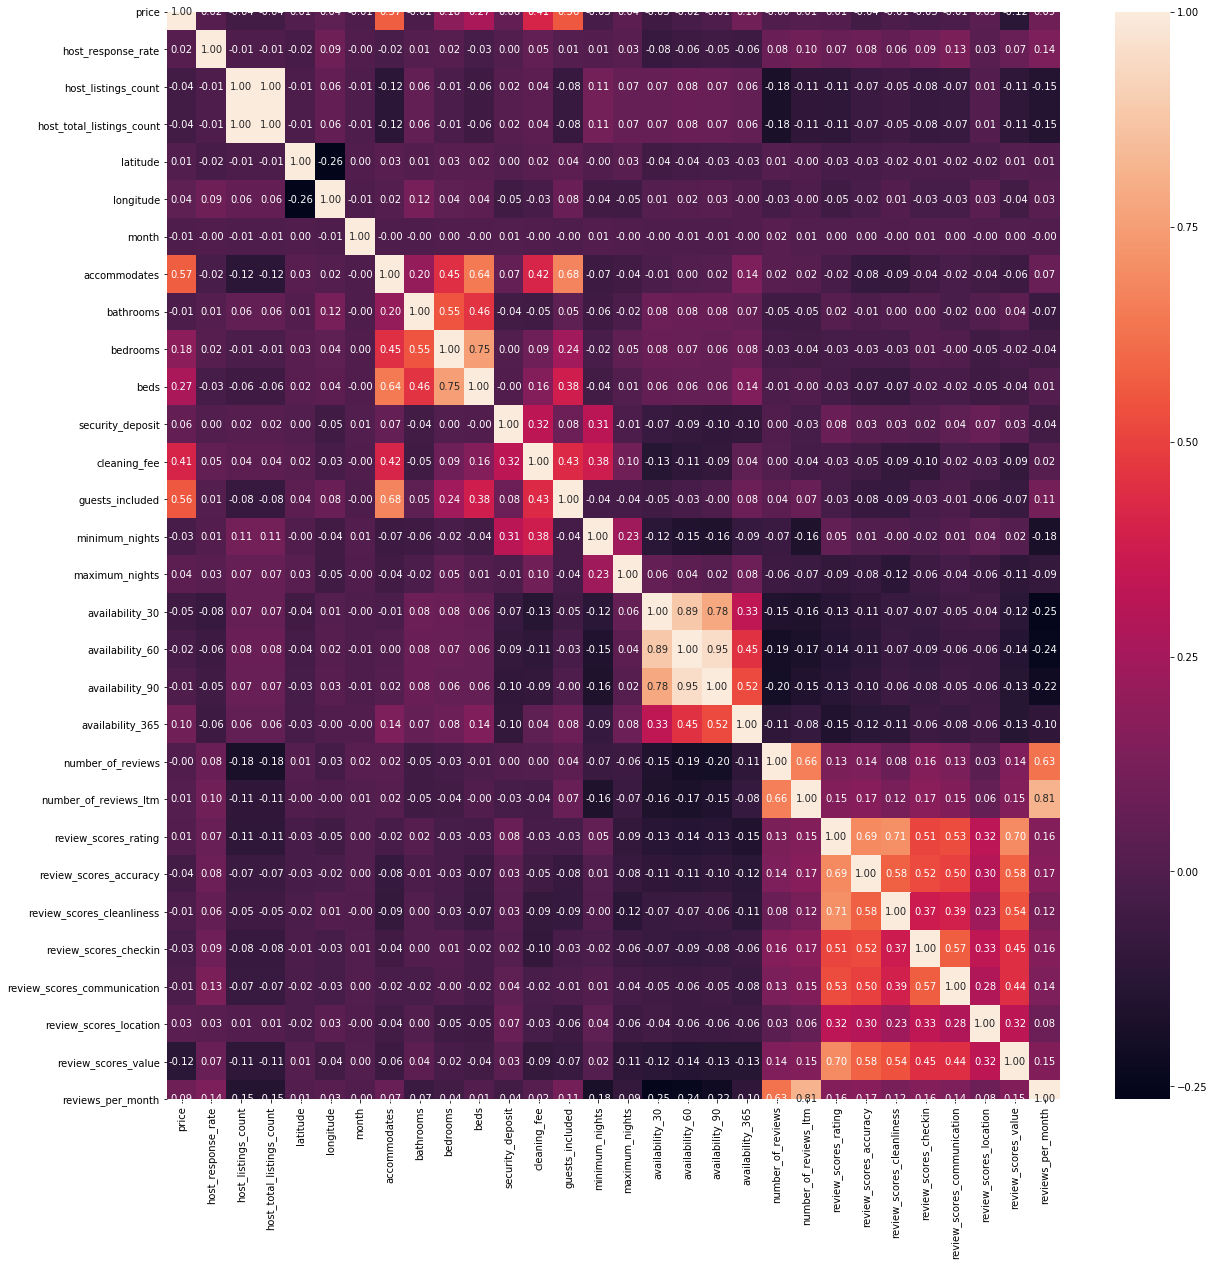

In [42]:
# Find out the correlations among numerical variables
cols = ['price', 'host_response_rate','host_listings_count','host_total_listings_count','latitude', 'longitude','month',
        'accommodates','bathrooms','bedrooms', 'beds', 'security_deposit','cleaning_fee','guests_included','minimum_nights',
        'maximum_nights','availability_30', 'availability_60','availability_90','availability_365',
        'number_of_reviews','number_of_reviews_ltm', 'review_scores_rating', 'review_scores_accuracy',
        'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication', 'review_scores_location',
        'review_scores_value', 'reviews_per_month']
plt.figure(figsize=(20,20))
sns.heatmap(df_new_clean[cols].corr(), annot=True, fmt='.2f');

In [43]:
# Pull a list of the column names of the categorical variables
cat_df = df_new_clean.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

In [44]:
# One-Hot Encoding - Convert Categorical variables into numerical representation without arbitrary ordering
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

df_new_clean_cat = create_dummy_df(df_new_clean, cat_cols_lst, dummy_na=False)
df_new_clean_cat.head()

,minimum_nights,maximum_nights,available_t,available_f,available_total,month,host_response_rate,host_listings_count,host_total_listings_count,latitude,...,property_type_Tiny house,property_type_Townhouse,property_type_Villa,room_type_Hotel room,room_type_Private room,room_type_Shared room,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_t
0,30,180,0,1,1,4,70.0,2.0,2.0,35.74267,...,0,0,0,0,0,0,0,0,1,1
1,30,180,0,1,1,4,100.0,2.0,2.0,35.74267,...,0,0,0,0,0,0,0,0,1,1
2,30,180,0,1,1,4,70.0,2.0,2.0,35.74267,...,0,0,0,0,0,0,0,0,1,1
3,30,180,0,1,1,4,100.0,2.0,2.0,35.74267,...,0,0,0,0,0,0,0,0,1,1
4,30,180,0,1,1,4,70.0,2.0,2.0,35.74267,...,0,0,0,0,0,0,0,0,1,1


In [45]:
df_new_clean_cat.shape[0]

1642972

In [46]:
# Convert numerical data into array:
# Labels are the values we want to predict
labels = np.array(df_new_clean_cat['price'])
# Remove the labels from the features
# axis 1 refers to the columns
features = df_new_clean_cat.drop('price', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [54]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
test_size = 0.3, stratify = labels, random_state = 42, shuffle = True)

In [55]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1150080, 115)
Training Labels Shape: (1150080,)
Testing Features Shape: (492892, 115)
Testing Labels Shape: (492892,)


In [56]:
# Train ML model by only numerical columns, with Random Forest
forest = RandomForestRegressor(n_estimators=100, 
                               criterion='mse', 
                               random_state=42, 
                               n_jobs=-1)
forest = forest.fit(train_features, train_labels.squeeze())

In [70]:
# Print out the mean absolute error (MAE), to compare to baseline
print('Mean Absolute Error, train: %.4f, test: %.4f' % (
        round(np.mean(errors_train)),
        round(np.mean(errors_test))))

# Print out the mean squared error (MSE)
print('MSE train: %.4f, test: %.4f' % (
        mean_squared_error(train_labels, train_labels_pred),
        mean_squared_error(test_labels, test_labels_pred)))

from math import sqrt

# Print out the root mean squared error (RMSE)
print('RMSE train: %.4f, test: %.4f' % (
        sqrt(mean_squared_error(train_labels, train_labels_pred)),
        sqrt(mean_squared_error(test_labels, test_labels_pred))))

# Print out the R-squared value (R²)
print('R^2 train: %.4f, test: %.4f' % (
        r2_score(train_labels, train_labels_pred),
        r2_score(test_labels, test_labels_pred)))

Mean Absolute Error, train: 0.0000, test: 0.0000
MSE train: 9.3615, test: 1817.5121
RMSE train: 3.0596, test: 42.6323
R^2 train: 1.0000, test: 1.0000


In [82]:
# Calculate scores for the model
train_labels_pred = forest.predict(train_features)
test_labels_pred = forest.predict(test_features)


In [72]:
# Extract feature importances (fi)
from sklearn.feature_selection import SelectFromModel
for feature in zip(feature_list, forest.feature_importances_):
    print(feature)

('minimum_nights', 0.00771185289936391)
('maximum_nights', 0.05019115114924088)
('available_t', 3.6210259525108955e-08)
('available_f', 1.5692581835664018e-09)
('available_total', 0.0)
('month', 6.31468902974534e-10)
('host_response_rate', 0.006513217650347346)
('host_listings_count', 0.012115484450910976)
('host_total_listings_count', 0.014028191459078928)
('latitude', 0.032382473326808096)
('longitude', 0.06606465399113744)
('accommodates', 0.3191327355007204)
('bathrooms', 0.013706310290294807)
('bedrooms', 0.01052634851310828)
('beds', 0.006766926663902279)
('security_deposit', 0.014679416013219298)
('cleaning_fee', 0.09080512548583207)
('guests_included', 0.06508912532244351)
('extra_people', 0.04603769231703056)
('availability_30', 0.00392001957743866)
('availability_60', 0.006989896623038078)
('availability_90', 0.006205974890793693)
('availability_365', 0.02497715689535642)
('number_of_reviews', 0.013083003003520909)
('number_of_reviews_ltm', 0.008531916202188884)
('review_scor

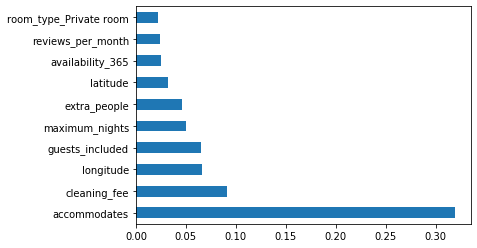

In [80]:
# Top 10 most important features - RandomForestRegressor
plt.figure()
feat_importances = pd.Series(forest.feature_importances_, index=feature_list)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [81]:
# Establish baseline
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('accommodates')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  11237.74


In [85]:
from sklearn.model_selection import KFold
from sklearn.svm import SVR

scores = []
best_svr = SVR(kernel='rbf', C=1, gamma=1)
cv = KFold(n_splits=10, random_state=42, shuffle=True)
for train_index, test_index in cv.split(features):
    print("Train Index: ", train_index, "\n")
    print("Test Index: ", test_index)

Train Index:  [      0       1       2 ... 1642969 1642970 1642971] 

Test Index:  [     23      29      31 ... 1642931 1642960 1642961]
Train Index:  [      0       1       3 ... 1642967 1642968 1642970] 

Test Index:  [      2      11      14 ... 1642957 1642969 1642971]
Train Index:  [      0       1       2 ... 1642969 1642970 1642971] 

Test Index:  [      5      13      19 ... 1642943 1642948 1642964]
Train Index:  [      0       1       2 ... 1642969 1642970 1642971] 

Test Index:  [      7      18      88 ... 1642958 1642963 1642965]
Train Index:  [      2       3       4 ... 1642969 1642970 1642971] 

Test Index:  [      0       1      12 ... 1642930 1642938 1642967]
Train Index:  [      0       1       2 ... 1642969 1642970 1642971] 

Test Index:  [      3      10      17 ... 1642941 1642942 1642945]
Train Index:  [      0       1       2 ... 1642968 1642969 1642971] 

Test Index:  [      6       9      32 ... 1642959 1642962 1642970]
Train Index:  [      0       1       2 ..

In [ ]:
best_svr.fit(train_features, train_labels)
scores.append(best_svr.score(test_features, test_labels))